In [50]:

import numpy as np
import torch
import torchvision as tv
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# Enable inline plotting for Jupyter note.
%matplotlib inline

In [51]:

sim_in = 20 * torch.rand((1000, 1)) - 10 
ground_truth = np.cos(sim_in.numpy())     

In [52]:

def calculate_params(input_model):
    total_params = sum(param.numel() for param in input_model.parameters() if param.requires_grad)
    return total_params


In [53]:

import torch.nn as nn
import torch.nn.functional as F

class NeuralOptimizer(nn.Module):
    def __init__(self):
        super(NeuralOptimizer, self).__init__()
        self.fc1 = nn.Linear(1, 9)
        self.fc2 = nn.Linear(9, 6)
        self.fc3 = nn.Linear(6, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [54]:

optim_net = NeuralOptimizer() 
cost_function = nn.MSELoss()   
optimizer = torch.optim.Adam(optim_net.parameters(), lr=0.001)  


In [55]:
def min_ratio(w):
    positive_count = sum(1 for x in w if x > 0)
    total_count = len(w)
    return positive_count / total_count if total_count > 0 else 0


In [56]:
def calculate_grad_norm(model):
    grad_norms = []
    
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if layer.weight.grad is not None:  
                grad_norm = layer.weight.grad.norm(2).item()
                grad_norms.append(grad_norm)
    
    return np.mean(grad_norms) if grad_norms else 0  


In [57]:
ground_truth_tensor = torch.tensor(ground_truth, dtype=torch.float32)

min_ratio_list = []
loss_list = []
train_count = 100

for i in range(train_count):
    EPOCHS = 1000
    total_loss = 0
    
    optim_net = NeuralOptimizer()  
    cost_function = nn.MSELoss()  
    optimizer = torch.optim.Adam(optim_net.parameters(), lr=0.001)
    
    for epoch in range(EPOCHS):
        optim_net.zero_grad()
        output = optim_net(sim_in)
        output = output.view_as(ground_truth_tensor)
        loss = cost_function(output, ground_truth_tensor)
        
        with torch.no_grad():
            total_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    loss_list.append(total_loss / len(sim_in))

    num_params = calculate_params(optim_net)
    
    H = torch.zeros((num_params, num_params))

    y_hat = optim_net(sim_in)
    loss = ((y_hat - sim_in)**2).mean()

    J = torch.autograd.grad(loss, list(optim_net.parameters()), create_graph=True)
    J = torch.cat([j.flatten() for j in J])

    for idx in range(num_params):
        grad_params = torch.autograd.grad(J[idx], list(optim_net.parameters()), retain_graph=True)
        H[idx] = torch.cat([g.flatten() for g in grad_params])

    eigenvalues, _ = np.linalg.eig(H.detach().numpy())
    min_ratio_list.append(min_ratio(eigenvalues))


In [58]:
num_params = calculate_params(optim_net)


In [59]:
num_params = calculate_params(optim_net)

H = torch.zeros((num_params, num_params))

y_hat = optim_net(sim_in)
y = sim_in
loss = ((y_hat - y)**2).mean()

J = torch.autograd.grad(loss, list(optim_net.parameters()), create_graph=True)
J = torch.cat([j.flatten() for j in J])

for i in range(num_params):
    grad_params = torch.autograd.grad(J[i], list(optim_net.parameters()), retain_graph=True)
    H[i] = torch.cat([g.flatten() for g in grad_params])


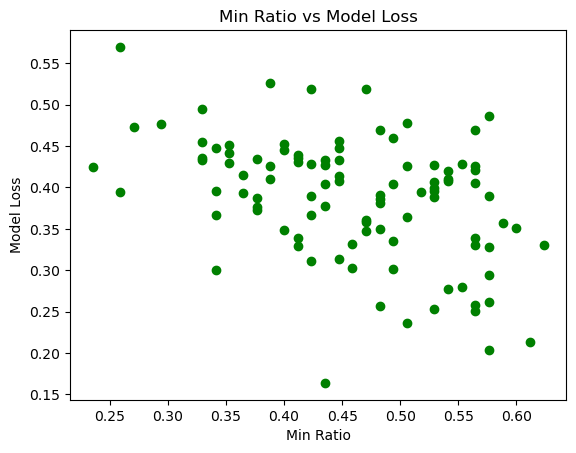

In [60]:
import matplotlib.pyplot as plt

# Create a scatter plot of Minimal Ratio vs Loss with new labels and colors
plt.scatter(min_ratio_list, loss_list, color='green', alpha=1)

# Adding new labels and title
plt.xlabel('Min Ratio')
plt.ylabel('Model Loss')
plt.title('Min Ratio vs Model Loss')

# Show the plot
plt.show()
